In [17]:

import torch
import numpy as np
import open3d as o3d
import copy
# import matplotlib
from matplotlib import pyplot as plt
#? einops is elegant and powerful in tensor operation. Check here for the tutorial -> https://einops.rocks/1-einops-basics/
from einops import rearrange, repeat 
from utils import  create_R, vis_world_bounds_o3d


(94, 352)


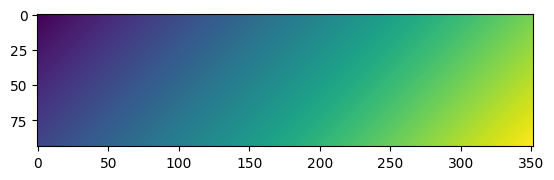

In [3]:
## Pixel Coordinate Sysyem
## About Meshgrid and indexing
H_raw, W_raw = 376, 1408 # Default rgb image resolution in KITTI-360
downscale = 4.
H, W = round(H_raw / downscale) , round(W_raw / downscale)
# np.meshgrid follow 'xy' indexing bydefault
u, v = np.meshgrid(np.linspace(0, W-1, W), np.linspace(0, H-1, H), indexing='xy')
print(u.shape)
uv_coordiante_np = np.stack((u / W,v / H), axis=-1) # shape [H, W, ()]
# In UV cooridinate system [0,0] denot the top-left pixel 
plt.imshow((u + v)/2)
# plt.show()

In [4]:
# init camera intrainsic and camera pose
K_raw = np.array([[552.554261,   0.      , 682.049453],
                 [  0.      , 552.554261, 238.769549],
                 [0., 0., 1.]])

K = K_raw[:2] / downscale

In [7]:
# World Coordinate System
%matplotlib widget
# In KITTI or KITTI-360, we set the world coordiante system as below
# We define the world coordiante system as X forward, Y left, Z up
# for camera on the car with 1.55m height and has ~5 degree inclination the, so rectify mat can make the origin "on the ground"
# see http://www.cvlibs.net/datasets/kitti-360/documentation.php for more detail 
car_height = 1.55
pi = 3.1415
camera_T = np.array((0,0,car_height))
camera_R = o3d.geometry.get_rotation_matrix_from_yxz((-np.pi/2,-np.pi/8 ,  0))
camera_pose = c2w = np.eye(4)
camera_pose[:3,:3] = camera_R
camera_pose[:3,3] = camera_T
c2w = camera_pose
w2c = camera_extrinsic = np.linalg.inv(c2w)
#? vector visualization -> https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib
''' camera_extrinsic = 
[[ux vx nx tx]
[uy vy ny ty]
[uz vz nz tz]
[0 0 0 1]]
U :right; V:up; N:look dir (for opengl only?)
-> https://medium.com/@carmencincotti/lets-look-at-magic-lookat-matrices-c77e53ebdf78
'''
right_vec = camera_extrinsic[:3,0] # X-axis in camera coordiante
up_vec =  camera_extrinsic[:3,1]# Y-axis ~
forward_vec = camera_extrinsic[:3,2] # Z-axis ~

V = np.stack((right_vec , up_vec, forward_vec), axis=-1)
origin = repeat(camera_T, 'C-> N C', N=3) # origin point

array([[ 6.12323400e-17,  3.08148791e-33,  1.00000000e+00],
       [ 3.82683432e-01,  9.23879533e-01, -2.34326020e-17],
       [-9.23879533e-01,  3.82683432e-01,  5.65713056e-17]])

In [25]:
# # Ray helpers
# Camera Coordinate System
# 这里我们约定z方向长度为1的方向向量为ray_direction, 归一化的方向向量成称之为viewdir(view = ray_direction / norm( ray_direction))
#? Difference between coordinate systems(opengl vs opencv) -> https://stackoverflow.com/questions/44375149/opencv-to-opengl-coordinate-system-transform
# The camera coordinates of OpenCV goes X right, Y down, Z forward. While the camera coordinates of OpenGL goes X right, Y up, Z inward.
# Ray helpers
def get_rays_torch(H, W, K, c2w, cam_type = 'opengl'):
    '''
    coordinata type: opengl, opencv
    '''
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    if cam_type == 'opengl':
        dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1)
    elif cam_type == 'opencv':
        dirs = torch.stack([(i-K[0][2])/K[0][0], (j-K[1][2])/K[1][1], torch.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d


def get_rays_np(H, W, K, c2w , cam_type = 'opengl'):
    '''
    coordinata type: opengl, opencv
    '''
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    if cam_type == 'opengl':
        dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1)
    elif cam_type == 'opencv':
        dirs = np.stack([(i-K[0][2])/K[0][0], (j-K[1][2])/K[1][1], np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d


def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, rays_d

In [19]:
# Init camera-to-world matrix in different camera space
cam_T = np.array((0,0,1.55))
cam_R = create_R((0,20 / 180 * pi,0,))

c2w_cv = create_c2w(cam_R_world=cam_R, cam_T_world=cam_T, cam_type='opencv')
c2w_gl = create_c2w(cam_R_world=cam_R, cam_T_world=cam_T, cam_type='opengl')


coordinate_world = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5)
coordinate_glcam = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3).transform(c2w_gl)
coordinate_cvcam = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3).transform(c2w_cv)


In [29]:
# Get Rays
rays_gl = get_rays_np(H=H, W=W, K = K, c2w = c2w_gl, cam_type = 'opengl')
rays_cv = get_rays_np(H=H, W=W, K = K, c2w = c2w_cv, cam_type = 'opencv')

assert np.sum(rays_cv[1] - rays_gl[1]) < 1e-7

In [12]:
#? open3d mesg transform -> http://www.open3d.org/docs/latest/tutorial/Basic/transformation.html
def draw_world_boundary(geo_group = [], bound = [0, 64, -32, 64, -2, 14]):
    pass


In [ ]:
# Visualize the whole world
import open3d as o3d
vis = o3d.visualization.Visualizer()
vis.create_window(width=1000, height=1000, visible= True)
bounds = np.array([20, 0, 10, -10, 4, -2])
# bounds = np.array([20, 0, 5, -5, 4, -2])

geo_group = []
geo_group += vis_world_bounds_o3d(bounds=bounds)
geo_group += [coordinate_world, coordinate_glcam, coordinate_cvcam]

for g in geo_group:
    vis.add_geometry(g)

vis.run()

In [13]:
# Ray AABB Intersection

In [14]:
# Load Tranform boundingbox

In [15]:
# Load a semantic voxel

In [16]:
# bunny = o3d.data.BunnyMesh()
# mesh = o3d.io.read_triangle_mesh(bunny.path)
# mesh.compute_vertex_normals()

# # Fit to unit cube.
# mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),
#             center=mesh.get_center())
# print('Displaying input mesh ...')
# o3d.visualization.draw([mesh])

# voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(
#     mesh, voxel_size=0.05)
# print('Displaying voxel grid ...')
# o3d.visualization.draw([voxel_grid])

Displaying input mesh ...
FEngine (64 bits) created at 0x7faf72b00000 (threading is enabled)
FEngine resolved backend: OpenGL


[error] GLFW error: Cocoa: Failed to find service port for display


Displaying voxel grid ...
